In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
#load the dataset
train = pd.read_csv('mnist_train.csv')
test = pd.read_csv('mnist_test.csv')
df = pd.concat([train, test], axis=0)
X = np.array(df.drop('label', axis=1))
y = np.array(df.label)

In [8]:
def model_inputs(input_shape, z_shape):
    '''
    Generates tensorflow placeholders for the inputs of the model
    
    Parameters:
    input_shape (int): Size of the input array
    z_shape (int): Size of the input array
    
    Returns:
    input_real (tf.placeholder): Placeholder for the real inputs
    input_z (tf.placeholder): Placeholder for the noise inputs
    '''
    input_real = tf.placeholder(tf.float32, shape=[None, input_shape], name='real_input')
    input_z = tf.placeholder(tf.float32, shape=[None, z_shape], name='z_input')
    return input_real, input_z

In [10]:
def generator(z, out_shape, n_units, alpha, reuse):
    '''
    Creates the generator model for the GAN
    
    Parameters:
    z (np.array): Noise to input in the generator
    out_shape (int): Size of the output layer
    n_units (int): Size of the hidden layer
    alpha (int): Parameter for the LeakyReLU activation function
    reuse (int): Parameter for the tf.variable_scope, whether to reuse the trainable variables
    
    Return:
    output (tensor): Output of the generator model
    '''
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, units=n_units, activation=None)
        h1 = tf.maximum(alpha*h1, h1)
        logits = tf.layers.dense(h1, units=out_shape, activation=None)
        output = tf.tanh(logits)
    return output

In [11]:
def discriminator(input_, n_units, alpha, reuse):
    '''
    Creates the discriminator model for the GAN
    
    Parameters:
    input_ (np.array): input of the discriminator
    n_units (int): Size of the hidden layer
    alpha (int): Parameter for the LeakyReLU activation function
    reuse (int): Parameter for the tf.variable_scope, whether to reuse the trainable variables
    
    Return:
    output (tensor): Output of the discriminator model
    logits (tensor): Logits of the discriminator model
    '''
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.dense(input_, units=n_units, activation=None)
        h1 = tf.maximum(alpha*h1, h1)
        logits = tf.layers.dense(h1, units=1, activation=None)
        output = tf.sigmoid(logits)
        return output, logits

In [12]:
#hyperparameters
input_shape = 784
z_shape = 100
n_units = 128
alpha = 0.01
smooth = 0.1

In [13]:
#build the tensorflow graph
tf.reset_default_graph()
input_real, input_z = model_inputs(input_shape, z_shape)
g_model = generator(input_z, input_shape, n_units, alpha, reuse=False)
d_model_real, d_logits_real = discriminator(input_real, n_units, alpha, reuse=False)
d_model_fake, d_logits_fake = discriminator(g_model, n_units, alpha, reuse=True)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [14]:
#calculate the cost functions
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(d_logits_real)*(1-smooth),
                                                         logits=d_logits_real))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(d_logits_fake), 
                                                         logits=d_logits_fake))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(d_logits_fake),
                                                        logits=d_logits_fake))

In [15]:
#build the optimizers
t_vars = tf.trainable_variables()
g_vars = tf.trainable_variables('generator')
d_vars = tf.trainable_variables('discriminator')

g_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)
d_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)

In [16]:
def generate_batch(X, y, batch_size=32):
    indicies = X.shape[0]
    n_batches = indicies//batch_size
    for ii in range(0, indicies, batch_size):
        yield X[ii:ii+batch_size], y[ii:ii+batch_size]

In [17]:
def normalize(X):
    '''
    Returns X with range between [-1,1]
    '''
    return 2*(X/X.max()) - 1

In [18]:
X = normalize(X)

In [19]:
samples = {}
epochs=100
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for input_, _ in generate_batch(X, y):
            batch_z = np.random.uniform(-1,1,size=(32,z_shape))
            _ = sess.run(d_opt, feed_dict = {input_real : input_, input_z: batch_z})
            _ = sess.run(g_opt, feed_dict = {input_z: batch_z})
        train_loss_d = sess.run(d_loss, feed_dict = {input_real : input_, input_z: batch_z})
        train_loss_g = g_loss.eval({input_z: batch_z})
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
        if e%10 == 0:
            sample_z = np.random.uniform(-1,1, size=(1, z_shape))
            img = sess.run(g_model, feed_dict={input_z:sample_z})
            samples[e] = img

Epoch 1/100... Discriminator Loss: 0.6388... Generator Loss: 4.5475
Epoch 2/100... Discriminator Loss: 1.8479... Generator Loss: 4.1910
Epoch 3/100... Discriminator Loss: 0.8824... Generator Loss: 4.6185
Epoch 4/100... Discriminator Loss: 1.7051... Generator Loss: 1.4883
Epoch 5/100... Discriminator Loss: 0.9016... Generator Loss: 2.9335
Epoch 6/100... Discriminator Loss: 1.1630... Generator Loss: 3.0115
Epoch 7/100... Discriminator Loss: 1.0346... Generator Loss: 2.3703
Epoch 8/100... Discriminator Loss: 1.1131... Generator Loss: 2.3270
Epoch 9/100... Discriminator Loss: 1.1927... Generator Loss: 1.8534
Epoch 10/100... Discriminator Loss: 0.9273... Generator Loss: 2.1101
Epoch 11/100... Discriminator Loss: 1.0768... Generator Loss: 1.9963
Epoch 12/100... Discriminator Loss: 1.1960... Generator Loss: 2.0419
Epoch 13/100... Discriminator Loss: 1.1990... Generator Loss: 1.7155
Epoch 14/100... Discriminator Loss: 1.0303... Generator Loss: 1.6347
Epoch 15/100... Discriminator Loss: 1.4178.

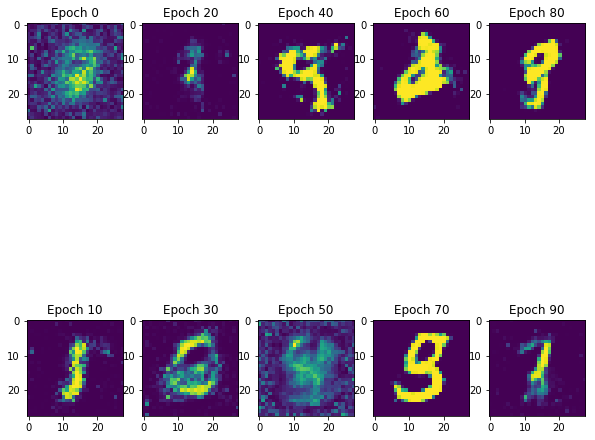

In [24]:
figs, axes = plt.subplots(2, 5, figsize=[10,10])
for i in range(10):
    axes[i%2][i//2].set_title('Epoch {}'.format(i*10))
    axes[i%2][i//2].imshow(samples[10*i].reshape(28,28))